<a href="https://colab.research.google.com/github/rbowery762/training/blob/master/Machine_Learning_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!echo "Downloading files..."
#!wget -q https://github.com/rbowery762/training/find/master

In [1]:
!echo "Unzipping files..."
!unzip -q /content/archive_half.zip

Unzipping files...


In [2]:
!echo "Merging training data..."
!mkdir /content/training
!rsync -a /content/train/ /content/training
!rsync -a /content/test/ /content/training
!rsync -a /content/valid/ /content/training



Merging training data...


In [13]:
# Import libraries
import pandas as pd                   
import tensorflow as tf 
from tensorflow import keras   
#import keras.api._v2.keras as keras    
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt   
import numpy as np                   
      
import cv2        
from google.colab.patches import cv2_imshow

In [4]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#    
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation. 


training_dir = '/content/training/'
image_size = (100, 100)

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

'''
ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		brightness_range=[0.2,0.8],
		shear_range=0.15,
		horizontal_flip=False,
		fill_mode="nearest")
'''

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
	    	rotation_range=0,
		    zoom_range=0,
		    width_shift_range=0,
		    height_shift_range=0,
				brightness_range=[0.7, 1],
		    shear_range=0,
		    fill_mode="nearest"
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
	    	rotation_range=0,
		    zoom_range=0,
		    width_shift_range=0,
		    height_shift_range=0,
				brightness_range=[0.7, 1],
		    shear_range=0,
		    fill_mode="nearest"
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse', 
        seed=42,shuffle=True)
#shuffle = False
validation_generator = validation_datagen.flow_from_directory(
        training_dir, 
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation", shuffle = False,
        seed=42)



Found 21202 images belonging to 177 classes.
Found 5217 images belonging to 177 classes.


train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
	    	#rotation_range=15,
		    #zoom_range=0.25,
		    #width_shift_range=0.2,
		    #height_shift_range=0.2,
				#brightness_range=[0.2,0.8],
		    #shear_range=0.15,
		    fill_mode="nearest"
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
	    	#rotation_range=15,
		    #zoom_range=0.25,
		    #width_shift_range=0.2,
		    #height_shift_range=0.2,
				#brightness_range=[0.2,0.8],
		    shear_range=0.15,
		    fill_mode="nearest"
        )

In [5]:
val_labels = validation_generator.labels

In [6]:
print(val_labels[800])

26


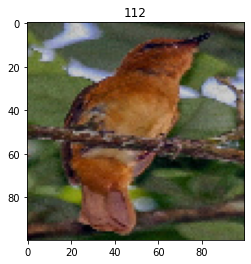

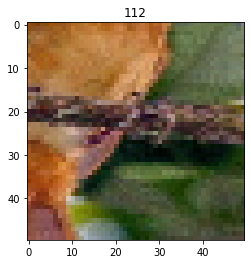

In [14]:
img = 12
#images are 100 by 100 pixels
plt.imshow(train_generator[0][0][img])
plt.title(int(train_generator[0][1][img])) 
plt.show()
plt.imshow(tf.image.stateless_random_crop(value = train_generator[0][0][img], size = (50,50,3), seed = [42,15]))
plt.title(int(train_generator[0][1][img]))
plt.show()

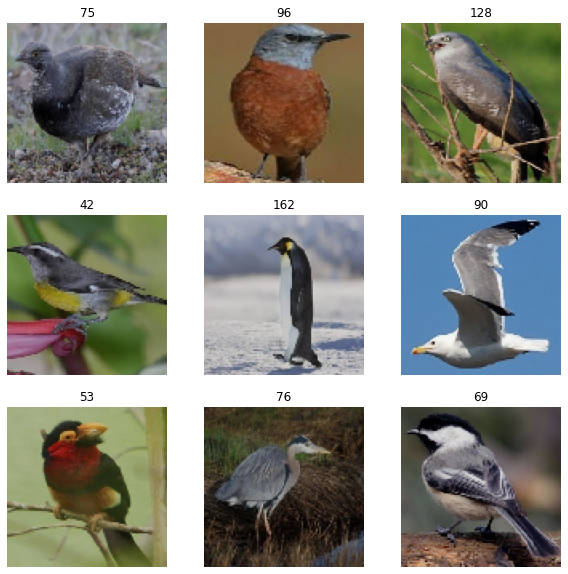

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        first_image = images.tolist()[i]      
        ax = plt.subplot(3, 3, i + 1)
        f = np.array(first_image)*255
        plt.imshow(f.astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    break

ResNet50

In [10]:
from tensorflow.keras.applications import ResNet50
 #input_shape=(244, 244, 3)  
base_model = ResNet50(input_shape=(100, 100, 3), include_top=False, weights="imagenet")


94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
#for layer in base_model.layers:  
#    layer.trainable = False          

In [28]:
from tensorflow.keras.applications import ResNet50
#from tensorflow.python.keras.models import Sequential 
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
        
earlyStop = tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights=True)
                            
base_model = keras.Sequential()       
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
#base_model.add(Flatten())   
base_model.add(Dense(177, activation='softmax'))               
 

In [29]:
opt = keras.optimizers.SGD(learning_rate=0.0001) 

In [30]:
#loss = 'binary_crossentropy'            
base_model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['acc'])

In [31]:
#, callbacks=[earlyStop]
resnet_history = base_model.fit(train_generator, validation_data = validation_generator, validation_steps = 1, steps_per_epoch = 100, epochs = 10, callbacks=[earlyStop])

Epoch 1/10


ValueError: ignored

In [20]:
predictions = base_model.predict(validation_generator)   

In [23]:
print(predictions)  

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [21]:
from numpy import argmax
predicted_classes = [np.argmax(probs) for probs in predictions]

In [22]:
from sklearn.metrics import classification_report
print(classification_report(val_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.01      1.00      0.01        34
           1       0.00      0.00      0.00        37
           2       0.00      0.00      0.00        36
           3       0.00      0.00      0.00        28
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00        28
           6       0.00      0.00      0.00        27
           7       0.00      0.00      0.00        27
           8       0.00      0.00      0.00        33
           9       0.00      0.00      0.00        34
          10       0.00      0.00      0.00        34
          11       0.00      0.00      0.00        26
          12       0.00      0.00      0.00        36
          13       0.00      0.00      0.00        35
          14       0.00      0.00      0.00        32
          15       0.00      0.00      0.00        27
          16       0.00      0.00      0.00        27
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Testing the model
Once you have built and trained your model, the next step is to run the test images through it and see how well your model does at making predictions for images it has never seen before. 

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `test_classes_partial.csv` to evaluate how well the model does.



```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test_partial'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



##Partial Hold out Dataset
You're given the answers to the first 200 images in the hold out dataset. 

Once you have predictions for the partial holdout dataset, you'll need to compare those predictions against the "ground truth" class labels in `test_classes_partial.csv` to evaluate how well the model does. 

Make sure to use the insights gained from the partial hold out dataset in your executive summary.

Once you feel confident, you will need to predict for the full test dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```